In [1]:
## doclayout_yolo
from huggingface_hub import hf_hub_download
from doclayout_yolo import YOLOv10
from pdf2image import convert_from_path
from pathlib import Path
import os
# Download model (one-time)
print("Downloading model...")
model_path = hf_hub_download(
    repo_id="juliozhao/DocLayout-YOLO-DocStructBench",
    filename="doclayout_yolo_docstructbench_imgsz1024.pt"
)
# Load model
print("Loading model...")
model = YOLOv10(model_path)
image_path="/home/anuj/DDC/data-ingestion/notebooks/page_3.png"
# image_path="/home/anuj/DDC/data-ingestion/pdf_pages/page_16.jpg"
result = model.predict(
    image_path,
    imgsz=1024,
    conf=0.25,
    save=True,
    project="runs/doclayout"
)
result

/home/anuj/DDC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...

image 1/1 /home/anuj/DDC/data-ingestion/notebooks/page_3.png: 1024x800 3 titles, 12 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 isolate_formula, 1 formula_caption, 3770.0ms
Speed: 14.8ms preprocess, 3770.0ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 800)
Results saved to runs/doclayout/predict


[doclayout_yolo.engine.results.Results object with attributes:
 
 boxes: doclayout_yolo.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'title', 1: 'plain text', 2: 'abandon', 3: 'figure', 4: 'figure_caption', 5: 'table', 6: 'table_caption', 7: 'table_footnote', 8: 'isolate_formula', 9: 'formula_caption'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255]

In [4]:
def sort_boxes_reading_order(result, line_threshold=50):
    """Sort detected boxes in reading order, handling multi-column layouts"""
    boxes = result[0].boxes
    
    elements = []
    for i in range(len(boxes.xyxy)):
        x1, y1, x2, y2 = boxes.xyxy[i].tolist()
        cls_id = int(boxes.cls[i])
        conf = float(boxes.conf[i])
        cls_name = result[0].names[cls_id]
        
        elements.append({
            'index': i,
            'bbox': (x1, y1, x2, y2),
            'type': cls_name,
            'class_id': cls_id,
            'confidence': conf,
            'y_center': (y1 + y2) / 2,
            'x_center': (x1 + x2) / 2,
            'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2
        })
    
    if not elements:
        return []
    
    # Get page width from image
    page_width = result[0].orig_shape[1]
    page_midpoint = page_width / 2
    
    # Separate full-width elements (titles, figures spanning both columns)
    # from column-specific elements
    full_width = []
    left_column = []
    right_column = []
    
    for elem in elements:
        elem_width = elem['x2'] - elem['x1']
        
        # If element spans more than 60% of page width, it's full-width
        if elem_width > page_width * 0.6:
            full_width.append(elem)
        # If element's center is in left half
        elif elem['x_center'] < page_midpoint:
            left_column.append(elem)
        else:
            right_column.append(elem)
    
    # Sort each group by y-position (top to bottom)
    full_width.sort(key=lambda e: e['y_center'])
    left_column.sort(key=lambda e: e['y_center'])
    right_column.sort(key=lambda e: e['y_center'])
    
    # Now interleave: full-width elements go in order,
    # then for each "row section", left column before right
    sorted_elements = []
    
    # Process by y-position zones
    all_elements = full_width + left_column + right_column
    all_elements.sort(key=lambda e: e['y1'])  # Sort by top edge
    
    # Group elements that are in the same vertical zone
    processed = set()
    
    for elem in all_elements:
        if elem['index'] in processed:
            continue
            
        elem_width = elem['x2'] - elem['x1']
        
        # Full-width element
        if elem_width > page_width * 0.6:
            sorted_elements.append(elem)
            processed.add(elem['index'])
        else:
            # Find all elements in this vertical zone
            zone_start = elem['y1']
            zone_end = elem['y2']
            
            # Extend zone to capture related elements
            zone_elements = []
            for e in all_elements:
                if e['index'] in processed:
                    continue
                e_width = e['x2'] - e['x1']
                if e_width > page_width * 0.6:
                    continue
                # Check if element overlaps with this zone
                if e['y1'] < zone_end + 50:  # Some tolerance
                    zone_elements.append(e)
                    zone_end = max(zone_end, e['y2'])
            
            # Sort zone elements: left column first, then right
            left_in_zone = [e for e in zone_elements if e['x_center'] < page_midpoint]
            right_in_zone = [e for e in zone_elements if e['x_center'] >= page_midpoint]
            
            left_in_zone.sort(key=lambda e: e['y_center'])
            right_in_zone.sort(key=lambda e: e['y_center'])
            
            for e in left_in_zone:
                if e['index'] not in processed:
                    sorted_elements.append(e)
                    processed.add(e['index'])
            
            for e in right_in_zone:
                if e['index'] not in processed:
                    sorted_elements.append(e)
                    processed.add(e['index'])
    
    return sorted_elements

In [6]:
sorted_elements = sort_boxes_reading_order(result)

## Step 1: Text extraction with Bounding boxes

In [2]:
import pymupdf
import cv2
import numpy as np

pdf_path = "/home/anuj/DDC/kb/agent0.pdf"
doc = pymupdf.open(pdf_path)
page = doc[2]

pdf_width = page.rect.width
pdf_height = page.rect.height
print(f"PDF page size: {pdf_width:.0f} x {pdf_height:.0f} points")

img_width = result[0].orig_shape[1]
img_height = result[0].orig_shape[0]
print(f"Image size: {img_width} x {img_height} pixels")

PDF page size: 612 x 792 points
Image size: 2550 x 3300 pixels


In [3]:
## Step 2: Co-ordinate Mapping
def pixel_to_pdf_coordinates(bbox, img_shape, pdf_page):
    """ Convert pixel coordinates to PDF coordinates."""
    img_height, img_width = img_shape
    pdf_width, pdf_height = pdf_page.rect.width, pdf_page.rect.height

    # Scale factors
    scale_x = pdf_width / img_width
    scale_y = pdf_height / img_height

    x1, y1, x2, y2 = bbox
    
    # convert to PDF co-ordinates
    pdf_x1 = x1 * scale_x
    pdf_y1 = y1 * scale_y
    pdf_x2 = x2 * scale_x
    pdf_y2 = y2 * scale_y

    return pymupdf.Rect(pdf_x1, pdf_y1, pdf_x2, pdf_y2)

In [10]:
## Testing with first text element
for elem in sorted_elements[:]:
    if elem['type'] in ['plain text', 'title']:
        pdf_rect = pixel_to_pdf_coordinates(elem['bbox'], result[0].orig_shape, page)
        text = page.get_text("text", clip=pdf_rect)
        print(f"\n[{elem['type']}]")
        print(f"Bbox: {elem['bbox']}")
        print(f"PDF Rect: {pdf_rect}")
        print(f"Text: {text}")
        # break


[plain text]
Bbox: (228.92868041992188, 1375.072265625, 1007.2557373046875, 1422.979736328125)
PDF Rect: Rect(54.94288330078125, 330.01734375, 241.74137695312498, 341.51513671875)
Text: as a regularization penalty to stabilize training.


[title]
Bbox: (229.2996368408203, 1486.3367919921875, 821.3922119140625, 1541.904052734375)
PDF Rect: Rect(55.031912841796874, 356.720830078125, 197.134130859375, 370.05697265624997)
Text: 3. The Agent0 Framework


[title]
Bbox: (228.33570861816406, 1573.1885986328125, 694.3635864257812, 1621.0821533203125)
PDF Rect: Rect(54.80057006835937, 377.56526367187496, 166.64726074218748, 389.05971679687497)
Text: 3.1. Framework Overview


[plain text]
Bbox: (228.16558837890625, 1651.23779296875, 1212.1640625, 2100.5087890625)
PDF Rect: Rect(54.7597412109375, 396.2970703125, 290.919375, 504.122109375)
Text: Agent0 is a fully autonomous, iterative co-evolutionary
framework designed to enhance the capabilities of LLM
agents without relying on any human-annotate

Found 1 figures


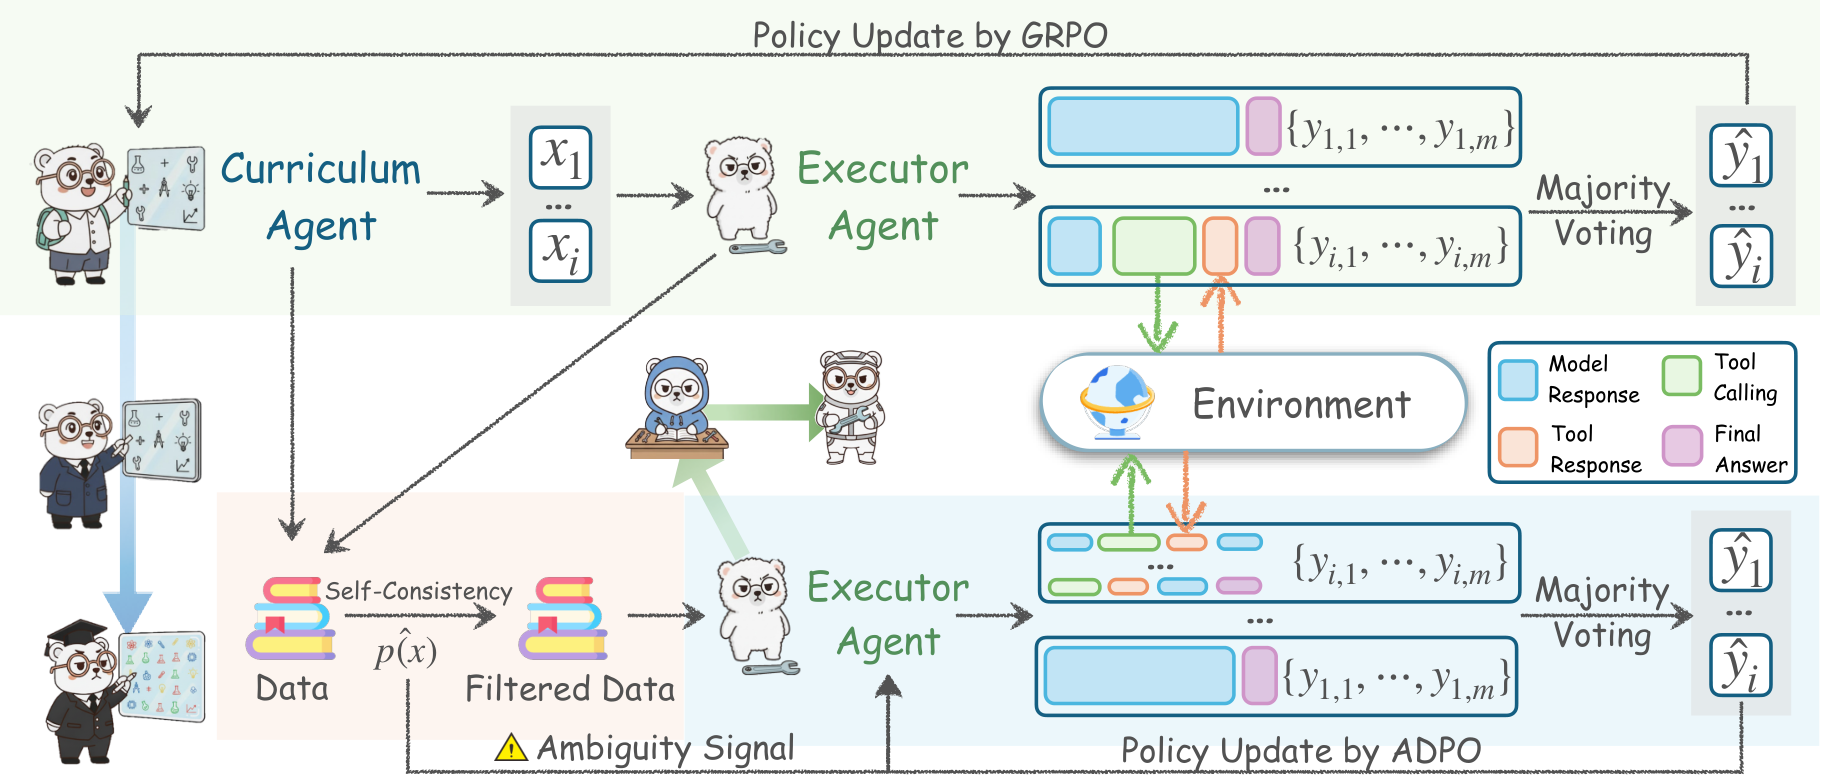

In [15]:
## Crop and display Figrures
# from IPython.display import display, Image as IPImage
from PIL import Image
import numpy as np
import cv2

# find figure elements
figures = [ele for ele in sorted_elements if ele['type'] == 'figure']
print(f"Found {len(figures)} figures")

# crop and display each figure
if figures:
    fig = figures[0]
    x1, y1, x2, y2 = [int(v) for v in fig['bbox']]

    # load page image with PIL
    page_img = Image.open(image_path)
    cropped_img = page_img.crop((x1, y1, x2, y2))
    display(cropped_img)
    # display(page_img)

In [17]:
## Caption linking
def find_caption_for_element(element, sorted_elements, element_type='figure'):
    """Find caption below a figure/table"""
    caption_type = f"{element_type}_caption"
    elem_bottom = element['bbox'][3]  # y2
    
    for other in sorted_elements:
        if other['type'] == caption_type:
            caption_top = other['bbox'][1]  # y1
            if 0 < (caption_top - elem_bottom) < 150:  # Within 150 pixels
                return other
    return None

# Test it
fig = figures[0]
caption_elem = find_caption_for_element(fig, sorted_elements, 'figure')

if caption_elem:
    pdf_rect = pixel_to_pdf_coordinates(caption_elem['bbox'], result[0].orig_shape, page)
    caption_text = page.get_text("text", clip=pdf_rect).strip()
    print("✅ Found Caption:")
    print(caption_text)
else:
    print("❌ No caption found nearby")

✅ Found Caption:
Figure 2. The Agent0 co-evolutionary loop. (1) Curriculum Evolution: The Curriculum Agent πθ is trained via RL to generate tasks,
maximizing a reward RC based on executor Uncertainty Runc, Tool Use Rtool and Repetition Penalty Rrep. (2) Executor Evolution: Tasks
are filtered by self-consistency score ˆp to create a challenging dataset D(t). The Executor Agent πϕ is then trained on D(t) via ADPO, an
ambiguity-aware RL method using majority-vote pseudo-labels ˜y.


## Extracting Table

In [19]:
result_p6 = model.predict("page_6.png", imgsz=1024, conf=0.25, save=True)
# Check for tables
tables = [i for i, cls in enumerate(result_p6[0].boxes.cls) 
          if result_p6[0].names[int(cls)] == 'table']
print(f"Found {len(tables)} tables on page 6")


image 1/1 /home/anuj/DDC/data-ingestion/notebooks/page_6.png: 1024x800 2 titles, 6 plain texts, 2 abandons, 2 tables, 2 table_captions, 3292.6ms
Speed: 16.3ms preprocess, 3292.6ms inference, 3.2ms postprocess per image at shape (1, 3, 1024, 800)
Results saved to runs/doclayout/predict
Found 2 tables on page 6


Table elements: 2


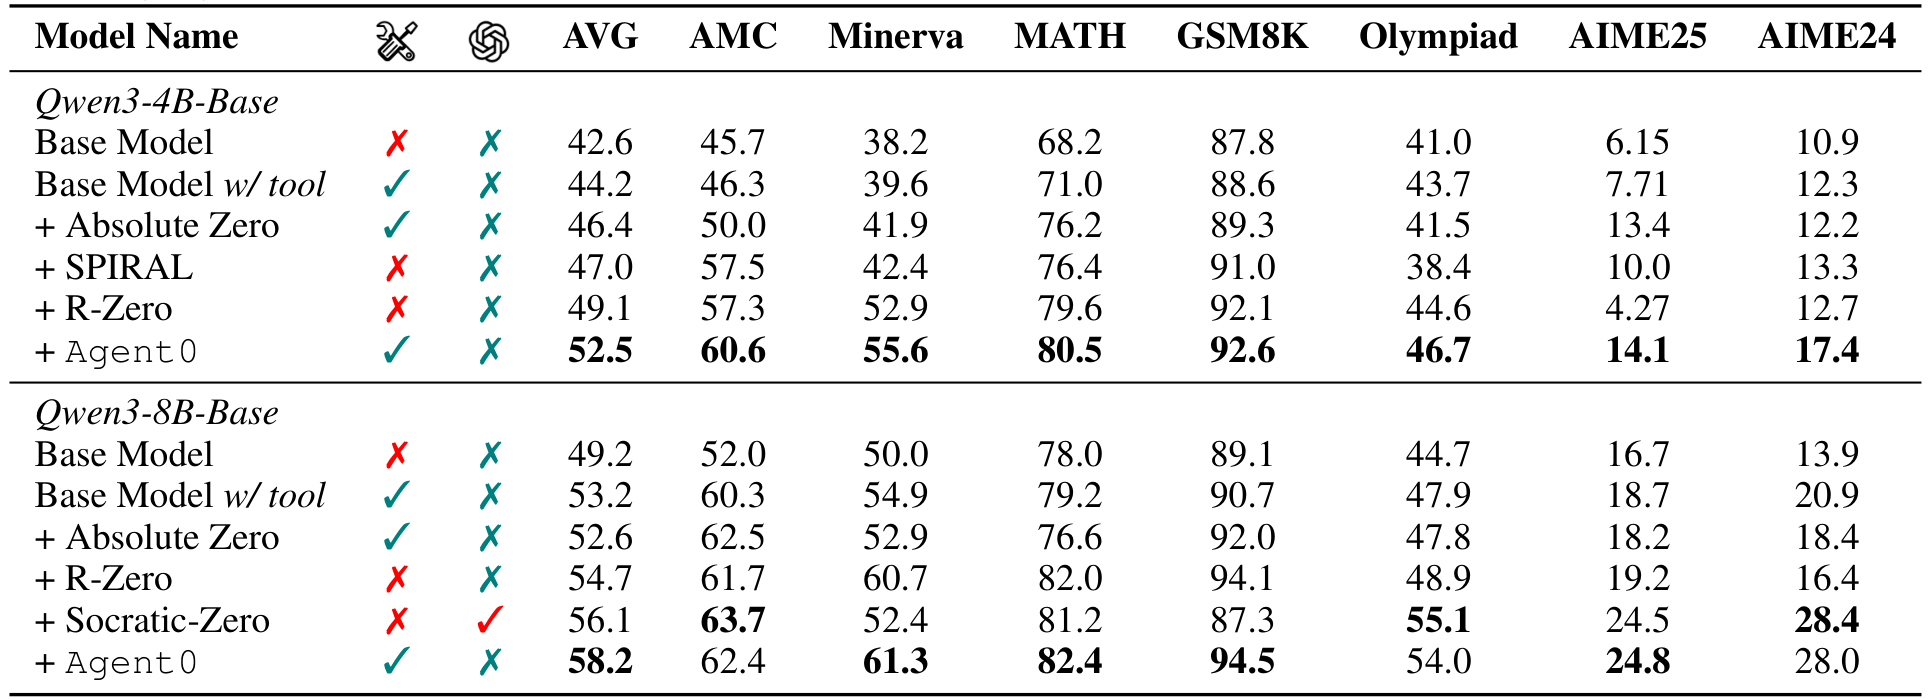

In [26]:
## Crop the table
from PIL import Image

sorted_p6 = sort_boxes_reading_order(result_p6)

# find table elements
table_elements = [ele for ele in sorted_p6 if ele['type'] == 'table']
print(f"Table elements: {len(table_elements)}")

if table_elements:
    table = table_elements[0]
    x1, y1, x2, y2 = [int(v) for v in table['bbox']]

    pil_image = Image.open("page_6.png")
    cropped_table = pil_image.crop((x1, y1, x2, y2))
    cropped_table.save("cropped_table.png")
    display(cropped_table)

In [32]:
# Debugging Table Extraction
print(f"PDF Page Size: {page_6.rect.width} x {page_6.rect.height}")
print(f"Image Size: {result_p6[0].orig_shape[1]} x {result_p6[0].orig_shape[0]}")

# 1. Try finding ALL tables on the page (no clip)
all_tables = page_6.find_tables()
print(f"\nPyMuPDF found {len(all_tables.tables)} tables on the full page.")

if all_tables.tables:
    print("First table detected by PyMuPDF:")
    display(all_tables.tables[0].to_pandas())
    
    # Check bounding box of the PyMuPDF detected table
    print(f"\nPyMuPDF Table BBox: {all_tables.tables[0].bbox}")
    
    # Compare with our calculated YOLO bbox
    print(f"YOLO Converted BBox: {pdf_rect}")
else:
    print("PyMuPDF found NO tables on this page even without clipping.")

PDF Page Size: 612.0 x 792.0
Image Size: 1700 x 2200

PyMuPDF found 0 tables on the full page.
PyMuPDF found NO tables on this page even without clipping.


In [33]:
from img2table.document import Image as Img2TableImage
from img2table.ocr import TesseractOCR

# 1. Use the cropped table image we saved earlier
# (If you don't have it, we'll re-crop it from page_6.png)
from PIL import Image
import cv2

# Re-crop to be sure
if table_elements:
    target_table = table_elements[0]
    x1, y1, x2, y2 = [int(v) for v in target_table['bbox']]
    
    # Load page image
    page_img_cv = cv2.imread("page_6.png")
    # Crop it
    cropped_table_cv = page_img_cv[y1:y2, x1:x2]
    cv2.imwrite("cropped_table_fixed.png", cropped_table_cv)
    print("✅ Table cropped.")

    # 2. Extract using img2table
    ocr = TesseractOCR(lang="eng")
    
    # Load the cropped table
    doc_table = Img2TableImage(src="cropped_table_fixed.png")

    # Extract
    extracted_tables = doc_table.extract_tables(
        ocr=ocr, 
        implicit_rows=True, 
        borderless_tables=True, 
        min_confidence=50
    )

    print(f"Extracted {len(extracted_tables)} tables")

    if extracted_tables:
        print("\nTable DataFrame:")
        display(extracted_tables[0].df)
    else:
        print("❌ img2table didn't find structure. Trying simple OCR...")
        import pytesseract
        text = pytesseract.image_to_string("cropped_table_fixed.png", config='--psm 6')
        print(text)
else:
    print("No table elements to crop.")

✅ Table cropped.
tesseract 5.3.4
 leptonica-1.82.0
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.5) : libpng 1.6.43 : libtiff 4.5.1 : zlib 1.3 : libwebp 1.3.2 : libopenjp2 2.5.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found OpenMP 201511
 Found libarchive 3.7.2 zlib/1.3 liblzma/5.4.5 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.5
 Found libcurl/8.5.0 OpenSSL/3.0.13 zlib/1.3 brotli/1.1.0 zstd/1.5.5 libidn2/2.3.7 libpsl/0.21.2 (+libidn2/2.3.7) libssh/0.10.6/openssl/zlib nghttp2/1.59.0 librtmp/2.3 OpenLDAP/2.6.7


AttributeError: module 'cv2.ximgproc' has no attribute 'niBlackThreshold'